# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from utils.gaussian_processes.gp_model import GPModel

2023-02-21 14:46:14.112077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 14:46:14.425683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-21 14:46:14.425726: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-21 14:46:14.476413: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-21 14:46:15.624811: W tensorflow/stream_executor/pla

# Data

In [2]:
# Load the data
# Load the data from the Scripps CO2 program website. 
co2_df = pd.read_csv(
    # Source: https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv
    './data/monthly_in_situ_co2_mlo.csv', 
    header=3, # Data starts here
    skiprows=[4, 5], # Headers consist of multiple rows
    usecols=[3, 4], # Only keep the 'Date' and 'CO2' columns
    na_values='-99.99',  # NaNs are denoted as '-99.99'
    dtype=np.float64
)

# Drop missing values
co2_df.dropna(inplace=True)
# Remove whitespace from column names
co2_df.rename(columns=lambda x: x.strip(), inplace=True)


# Split the data into observed and to predict
date_split_predict = 2010
df_observed = co2_df[co2_df.Date < date_split_predict]
print('{} measurements in the observed set'.format(len(df_observed)))
df_predict = co2_df[co2_df.Date >= date_split_predict]
print('{} measurements in the test set'.format(len(df_predict)))

617 measurements in the observed set
133 measurements in the test set


In [3]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133 entries, 624 to 756
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    133 non-null    float64
 1   CO2     133 non-null    float64
dtypes: float64(2)
memory usage: 3.1 KB


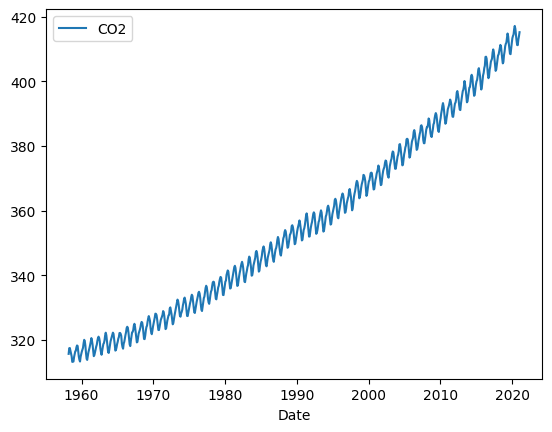

In [4]:
co2_df.plot(x="Date", y="CO2");

# Gaussian Process

In [5]:
gp_model = GPModel()

In [6]:
gp_model.fit(df_observed=df_observed, x_col="Date", y_col="CO2", epochs=1000)

from dataloader.load_regression_data import RegressionDataGenerator

2023-02-21 14:46:18.723536: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-21 14:46:18.723583: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-21 14:46:18.723609: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2023-02-21 14:46:18.725433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
  0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.


loss = 189.242: 100%|██████████| 1000/1000 [00:31<00:00, 31.34it/s]


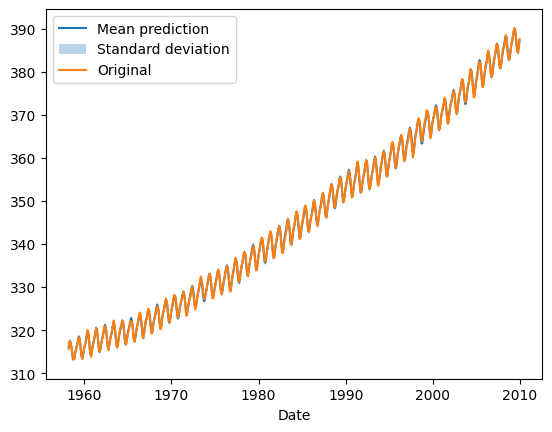

In [7]:
gp_model.plot_posterior();

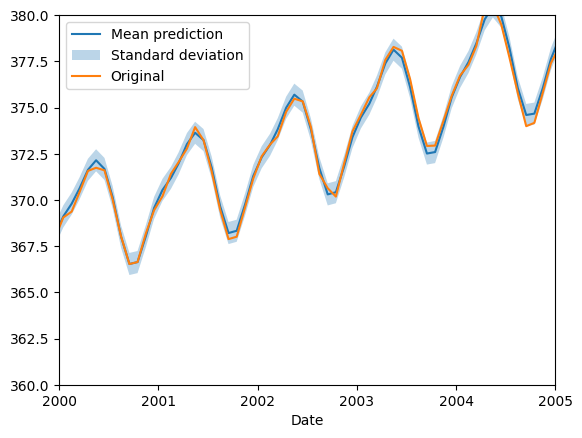

In [8]:
gp_model.plot_posterior()
plt.xlim(2000, 2005)
plt.ylim(360, 380);

# DataGenerator

In [9]:
df_predict = df_observed[df_observed["Date"].between(2000, 2010)]

In [10]:
data_generator = RegressionDataGenerator(gp_model=gp_model,
                                         df_predict=df_predict,
                                         iterations=100,
                                         batch_size=16,
                                         min_num_context=10,
                                         max_num_context=20,
                                         min_num_target=10,
                                         max_num_target=20)

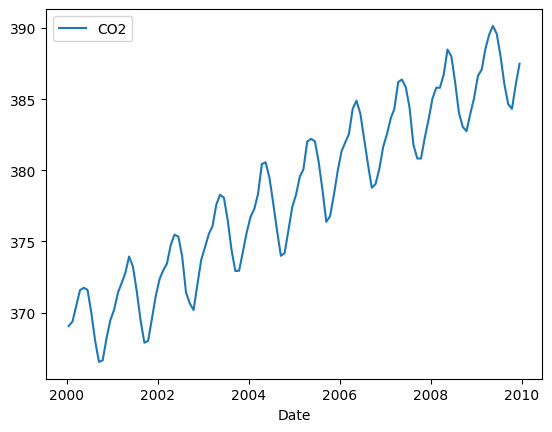

In [11]:
df_predict.plot(x="Date", y="CO2");

(<Figure size 800x500 with 1 Axes>, <AxesSubplot: >)

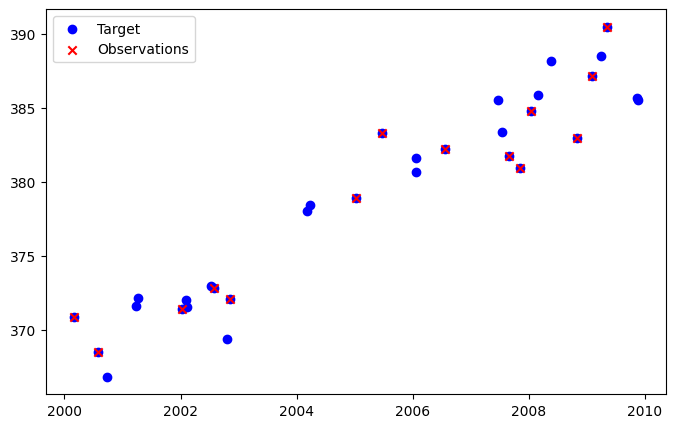

In [12]:
data_generator.plot_first_elt_of_random_batch()

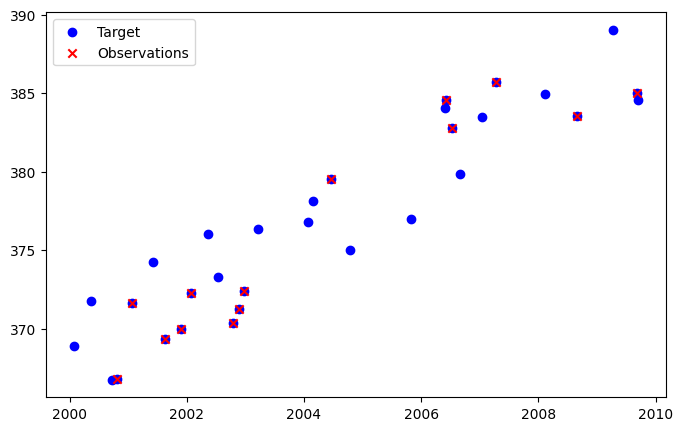

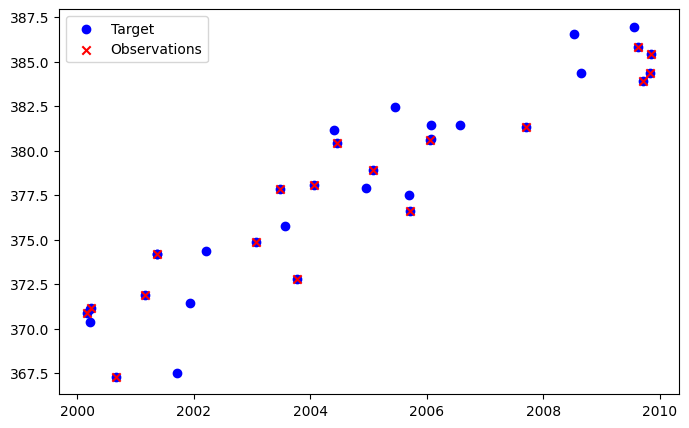

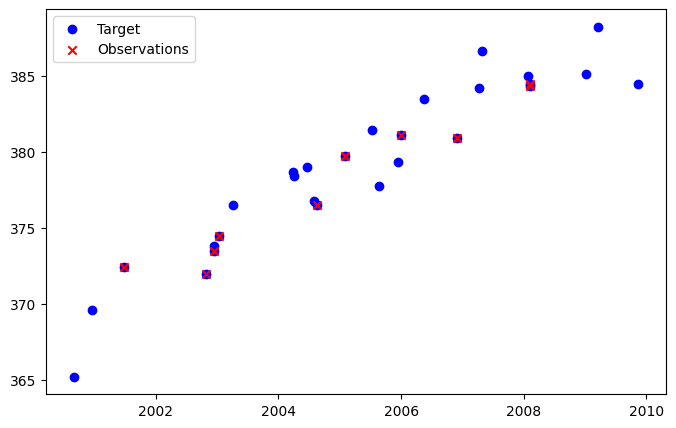

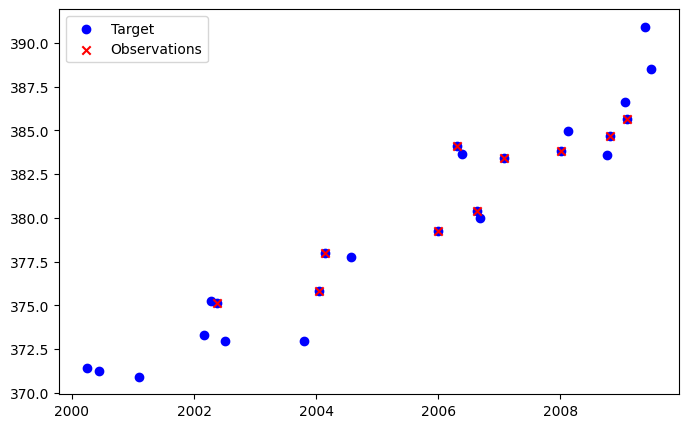

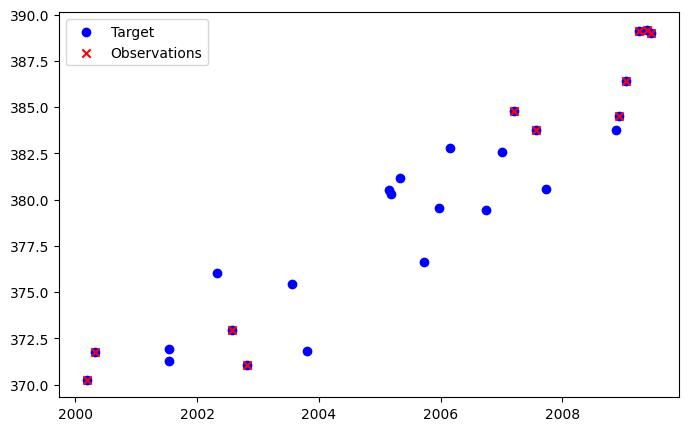

In [13]:
for (context_x, context_y, target_x), target_y in data_generator.train_ds.take(5):
    RegressionDataGenerator.plot_first_elt_of_batch(context_x, context_y, target_x, target_y)

# Conditional Neural Process

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from model import ConditionalNeuralProcess
from utils.gaussian_processes.plot_gp_utils import plot_preds_from_ds_test
from utils.plot import plot_learning_curve

encoder_dims = [500, 500, 500, 500]
decoder_dims = [500, 500, 500, 2]

def loss(target_y, pred_y):
    # Get the distribution
    mu, sigma = tf.split(pred_y, num_or_size_splits=2, axis=-1)
    dist = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    return -dist.log_prob(target_y)

model = ConditionalNeuralProcess(encoder_dims, decoder_dims)
model.compile(loss=loss, optimizer='adam')

In [ ]:
history = model.fit(data_generator.train_ds, validation_data=data_generator.test_ds, epochs=10)

Epoch 1/10
100/100 [==============================] - 181s 2s/step - loss: 1800.0820 - val_loss: 1784.8236
Epoch 2/10
 46/100 [============>.................] - ETA: 1:02 - loss: 1740.4540

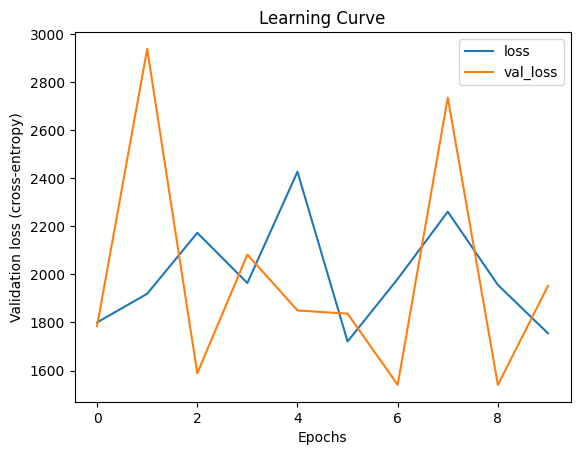

In [21]:
plot_learning_curve(history)

1/1 [==============================] - 0s 122ms/step


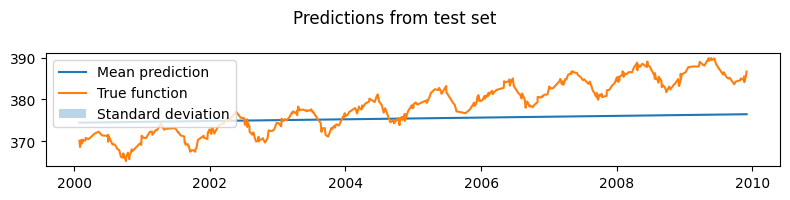

In [22]:
fig = plot_preds_from_ds_test(model, ds_test=data_generator.test_ds, num_samples=1);